# Bike Sharing Demand

- 도시 자전거 공유 시스템 사용 예측
- [캐글](https://www.kaggle.com)의 [Bike Sharing Demand](https://www.kaggle.com/c/bike-sharing-demand)에서 `train.csv`와 `test.csv`를 다운로드
- 두 파일을 각각 datasets 디렉토리에 bike_train.csv bike_test.csv로 저장 

## 1. 문제 정의
- 자전거 대여량을 예측하는 문제
- Evaluation : Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE). 

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 2. 데이터 가져오기

In [11]:
bike_train = pd.read_csv('datasets/bike_train.csv') # 훈련 데이터
bike_test = pd.read_csv('datasets/bike_test.csv') # 테스트 데이터
submission = pd.read_csv('datasets/sampleSubmission.csv') # 제출 샘플 데이터

In [12]:
bike_train.shape, bike_test.shape

((10886, 12), (6493, 9))

## 3. 데이터 훑어보기

In [13]:
bike_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [14]:
bike_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [15]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


datetime: hourly date + timestamp  
season: 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울  
holiday: 1 = 토, 일요일의 주말을 제외한 국경일 등의 휴일, 0 = 휴일이 아닌 날  
workingday: 1 = 토, 일요일의 주말 및 휴일이 아닌 주중, 0 = 주말 및 휴일  
weather:  
• 1 = 맑음, 약간 구름 낀 흐림  
• 2 = 안개, 안개 + 흐림  
• 3 = 가벼운 눈, 가벼운 비 + 천둥  
• 4 = 심한 눈/비, 천둥/번개  
temp: 온도(섭씨)   
atemp: 체감온도(섭씨)  
humidity: 상대습도  
windspeed: 풍속  
casual: 사전에 등록되지 않는 사용자가 대여한 횟수  
registered: 사전에 등록된 사용자가 대여한 횟수  
count: 대여 횟수  

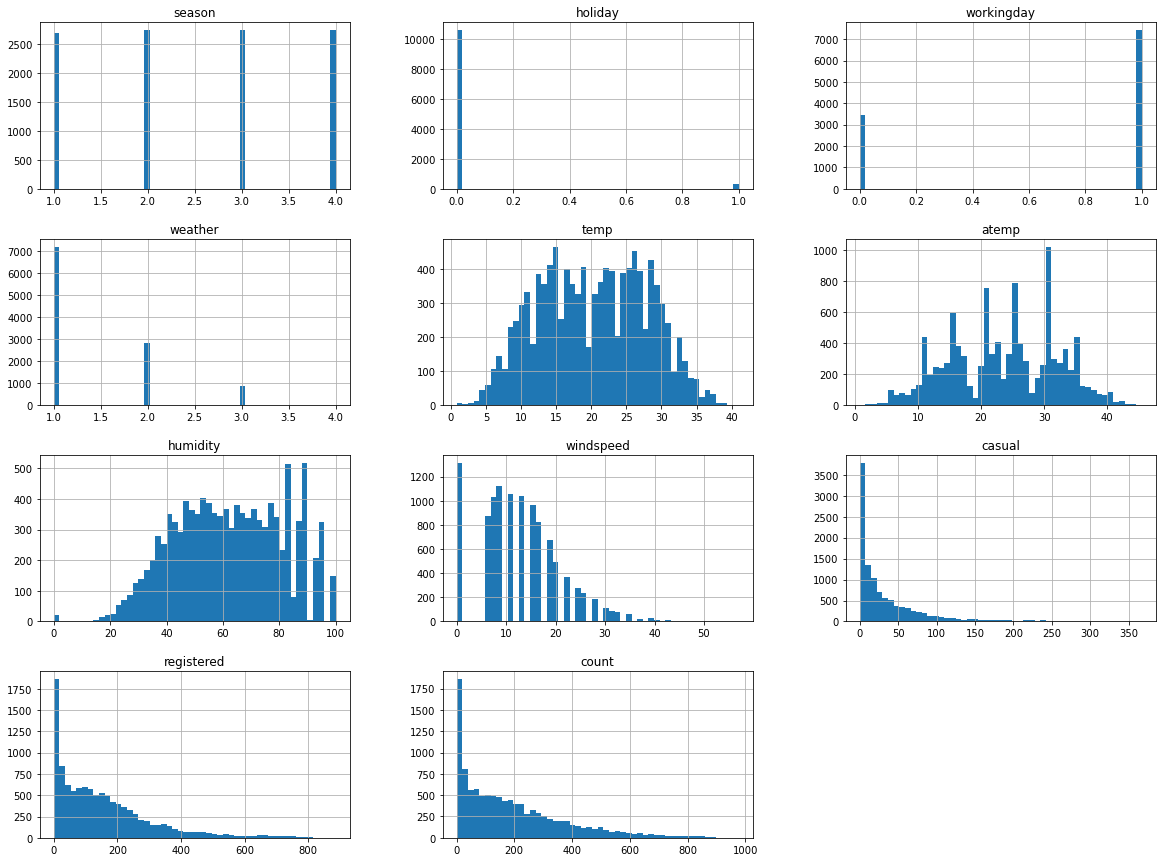

In [16]:
h = bike_train.hist(bins=50, figsize=(20, 15))

* target 값(count 열) 의 분포가 오른쪽으로 꼬리가 긴 모양

In [17]:
bike_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [18]:
bike_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


* 누락데이터는 없으나, datetime 의 타입이 문자열로 되어 있음
* 효과적인 분석을 위해 datetime 특성을 datetime(pandas에서 제공하는 타입)으로 바꾼 뒤
* 년, 월, 일, 시간 추출

In [19]:
bike_train['datetime'] = bike_train.datetime.apply(pd.to_datetime)

In [20]:
bike_train['year'] = bike_train.datetime.apply(lambda x : x.year)
bike_train['month'] = bike_train.datetime.apply(lambda x : x.month)
bike_train['day'] = bike_train.datetime.apply(lambda x : x.day)
bike_train['hour'] = bike_train.datetime.apply(lambda x : x.hour)
bike_train['minute'] = bike_train.datetime.apply(lambda x : x.minute)
bike_train['dayofweek'] = bike_train.datetime.apply(lambda x : x.dayofweek) # 요일

- season과 weather 컬럼을 숫자에서 실제 의미 있는 단어로 표시
- **season** (1 = 봄,  2 = 여름, 3 = 가을, 4 = 겨울  )
- **weather** (1 = 맑음, 약간 구름 낀 흐림, 2 = 안개, 안개 + 흐림, 3 = 가벼운 눈, 가벼운 비 + 천둥, 4 = 심한 눈/비, 천둥/번개)

In [21]:
bike_train['season'] = bike_train['season'].map({1 : 'Spring', 
                                                 2 : 'Summer',
                                                 3 : 'Fall', 
                                                 4 : 'Winter'})

bike_train['weather'] = bike_train['weather'].map({1 : 'Clear', 
                                                   2 : 'Mist, Few clouds',
                                                   3 : 'Light Snow, Rain, Thunder',
                                                   4 : 'Heavy Snow, Rain, Thunder'})

In [22]:
bike_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,dayofweek
0,2011-01-01 00:00:00,Spring,0,0,Clear,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,5
1,2011-01-01 01:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,5
2,2011-01-01 02:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,5
3,2011-01-01 03:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,5
4,2011-01-01 04:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,5


## 4. 데이터 탐색

### 4.1 타깃값(count) 의 분포도 그려보기

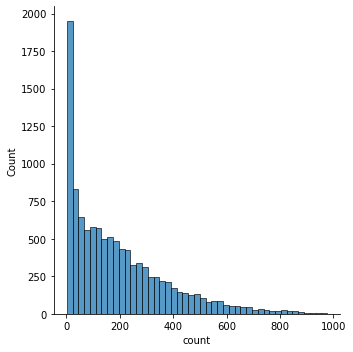

In [23]:
sns.displot(bike_train['count'])

- x축은 타깃값 count, y축은 빈도수(횟수)
- 오른쪽으로 꼬리가 긴 분포
- 회귀 모델이 좋은 성능 내려면 데이터가 정규분포를 따르는게 좋음
- 따라서 타깃값으 정규분포에 가깝게 만들기 위해 로그 변환 사용

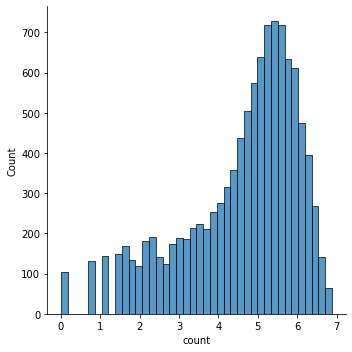

In [24]:
sns.displot(np.log(bike_train['count']))

### 4.2 대여 시간대(년, 월, 일, 요일, 시간, 분) 에 따른 자전거 대여율
범주형 데이터에 따른 수치형 데이터의 평균값(막대그래프)

In [25]:
bike_train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'minute', 'dayofweek'],
      dtype='object')

[Text(0.5, 1.0, 'number of rentals per minute')]

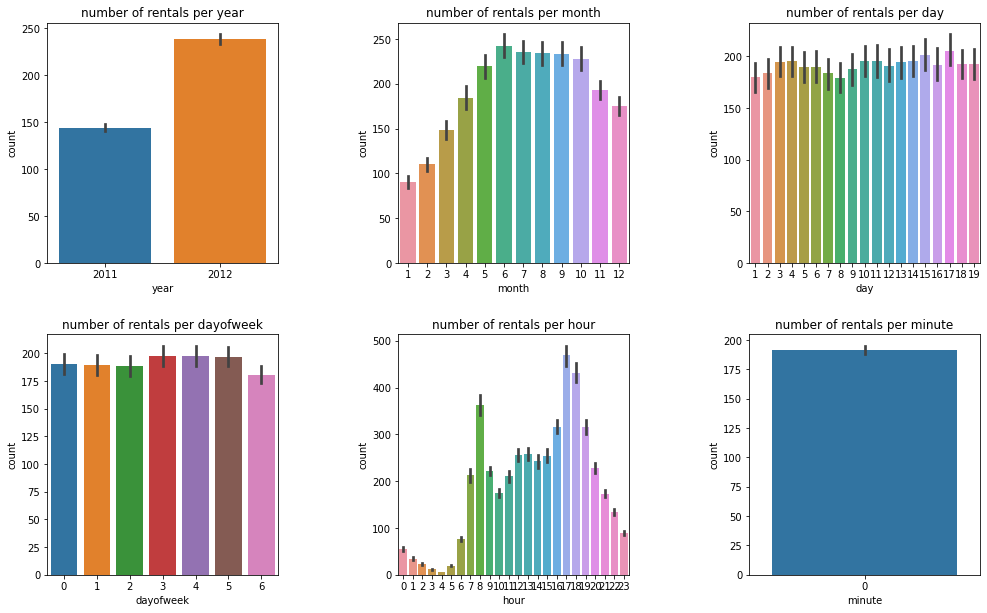

In [26]:
figure, axes = plt.subplots(nrows=2, ncols=3)
plt.tight_layout()
figure.set_size_inches(15, 9)

sns.barplot(data=bike_train, x="year", y="count", ax=axes[0][0]) # 년도별 자전거 대여량의 평균
sns.barplot(data=bike_train, x="month", y="count", ax=axes[0][1]) # 월별 자전거 대여량의 평균
sns.barplot(data=bike_train, x="day", y="count", ax=axes[0][2]) # 날짜별 자전거 대여량의 평균

sns.barplot(data=bike_train, x="dayofweek", y="count", ax=axes[1][0]) # 요일별 자전거 대여량의 평균
sns.barplot(data=bike_train, x="hour", y="count", ax=axes[1][1]) # 시간별 자전거 대여량의 평균
sns.barplot(data=bike_train, x="minute", y="count", ax=axes[1][2]) # 분별 자전거 대여량의 평균


axes[0][0].set(title="number of rentals per year")
axes[0][1].set(title="number of rentals per month")
axes[0][2].set(title="number of rentals per day")

axes[1][0].set(title="number of rentals per dayofweek")
axes[1][1].set(title="number of rentals per hour")
axes[1][2].set(title="number of rentals per minute")

* 년도별 대여량은 2011년보다 2012년이 더 많음
* 월별 대여량은 6월에 가장 많고, 7~10월도 대여량이 많음. 1월이 가장 적음
* 일별 대여량은 1일부터 19일까지만 데이터가 있고 예측력도 없어 보임. 20~31일 데이터는 테스트 데이터에 있음(사용불가)
* 시간대 대여량은 오전 8시, 오후 17~18시에 에 많은것으로 보아 출퇴근 시간대로 추측(주말과 평일을 나누어 분석해보기)

### 4.3 대여 시간대를 제외한 다른 범주형 데이터(계절, 날씨, 공휴일여부 등)에 따른 자전거 대여율

In [27]:
bike_train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'minute', 'dayofweek'],
      dtype='object')

[Text(0, 0, 'Clear'),
 Text(1, 0, 'Mist, Few clouds'),
 Text(2, 0, 'Light Snow, Rain, Thunder'),
 Text(3, 0, 'Heavy Snow, Rain, Thunder')]

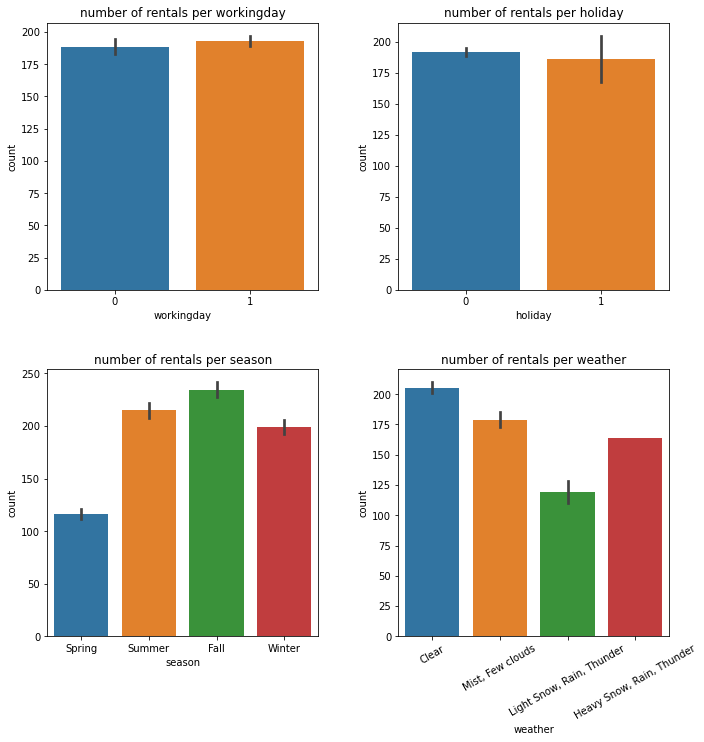

In [28]:
figure, axes = plt.subplots(nrows=2, ncols=2)
plt.tight_layout()
figure.set_size_inches(10, 10)

sns.barplot(data=bike_train, x="workingday", y="count", ax=axes[0][0]) 
sns.barplot(data=bike_train, x="holiday", y="count", ax=axes[0][1]) 

sns.barplot(data=bike_train, x="season", y="count", ax=axes[1][0]) 
sns.barplot(data=bike_train, x="weather", y="count", ax=axes[1][1]) 



axes[0][0].set(title="number of rentals per workingday")
axes[0][1].set(title="number of rentals per holiday")

axes[1][0].set(title="number of rentals per season")
axes[1][1].set(title="number of rentals per weather")

axes[1][1].set_xticklabels(axes[1][1].get_xticklabels(), rotation=30)

- 가을(Fall, 3)에 대여량이 많음 (앞의 month 특성과 겹치는 부분이 있음)
- 데이터가 지나치게 세분화 되어 있으면 분류별 데이터수가 적이지므로 month 특성 제거 고려
- 날씨가 좋을수록 대여 수량이 많음
- 그러나 heavy snow 기상상태에서 160건 이상의 대여량이 있는것이 이상

In [29]:
bike_train.groupby("weather").size() # countplot

weather
Clear                        7192
Heavy Snow, Rain, Thunder       1
Light Snow, Rain, Thunder     859
Mist, Few clouds             2834
dtype: int64

In [30]:
bike_train.groupby("weather").mean()['count'] # barplot

weather
Clear                        205.236791
Heavy Snow, Rain, Thunder    164.000000
Light Snow, Rain, Thunder    118.846333
Mist, Few clouds             178.955540
Name: count, dtype: float64

### 4.4 위의 범주형 데이터(계절, 날씨, 공휴일 여부 등)의 사분위 분포 확인

[Text(0, 0, 'Clear'),
 Text(1, 0, 'Mist, Few clouds'),
 Text(2, 0, 'Light Snow, Rain, Thunder'),
 Text(3, 0, 'Heavy Snow, Rain, Thunder')]

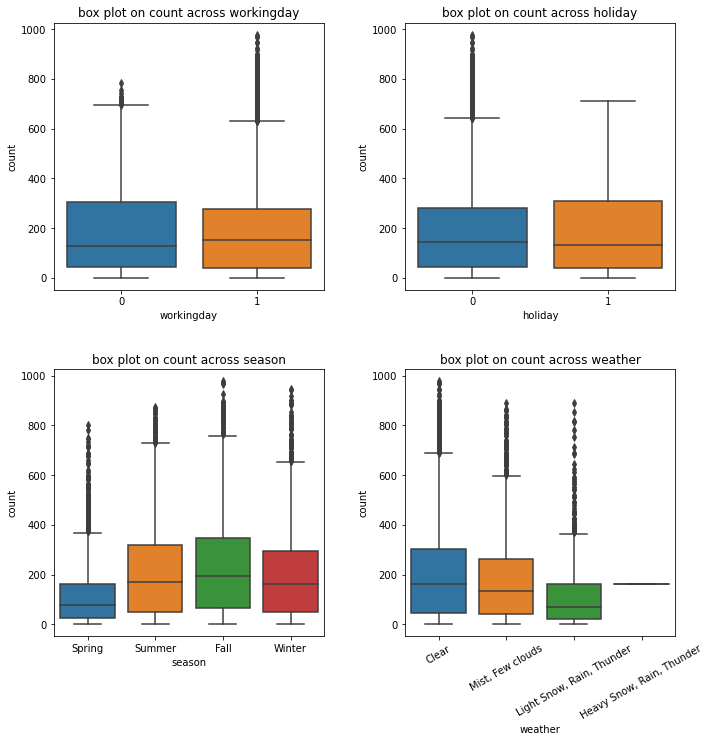

In [31]:
figure, axes = plt.subplots(nrows=2, ncols=2)
plt.tight_layout()
figure.set_size_inches(10, 10)

sns.boxplot(data=bike_train, x="workingday", y="count", ax=axes[0][0]) 
sns.boxplot(data=bike_train, x="holiday", y="count", ax=axes[0][1]) 

sns.boxplot(data=bike_train, x="season", y="count", ax=axes[1][0]) 
sns.boxplot(data=bike_train, x="weather", y="count", ax=axes[1][1]) 



axes[0][0].set(title="box plot on count across workingday")
axes[0][1].set(title="box plot on count across holiday")

axes[1][0].set(title="box plot on count across season")
axes[1][1].set(title="box plot on count across weather")

axes[1][1].set_xticklabels(axes[1][1].get_xticklabels(), rotation=30)

- 공휴일이 아닐 때 특잇값(outlier)가 많음
- 근무일일 때 특잇값이 많음
- 가을(Fall, 3)에 대여량이 많음
- 날씨가 좋을수록 대여량이 많음
- 악천후 속 자전거 대여수 한건(특잇값)데 대해 제거 고려

### 4.5 시간대별 자건거 대여율을 추가 정보와 함께 보기
추가정보 : 공휴일여부

<AxesSubplot:xlabel='hour', ylabel='count'>

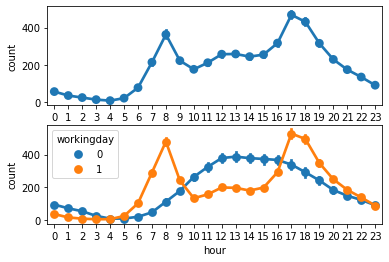

In [32]:
figure, (ax1, ax2) = plt.subplots(nrows=2)
sns.pointplot(data=bike_train, x="hour", y="count", ax=ax1) # 시간별 자전거 대여량의 평균
sns.pointplot(data=bike_train, x="hour", y="count", hue='workingday', ax=ax2)

* 근무일에는 출퇴근 시간에 대여량이 많고
* 쉬는날에는 오후 12~2시 사이에 대여량이 많음

### 4.6 상관관계
수치형 데이터 간 상관관계를 파악하기 위해 산점도 그래프(회귀선 포함한) 그리기

- **(1)** 온도, 체감온도, 습도, 풍속별 대여 수량 산점도 그래프('temp', 'atemp', 'humidity', 'windspeed')

<AxesSubplot:xlabel='windspeed', ylabel='count'>

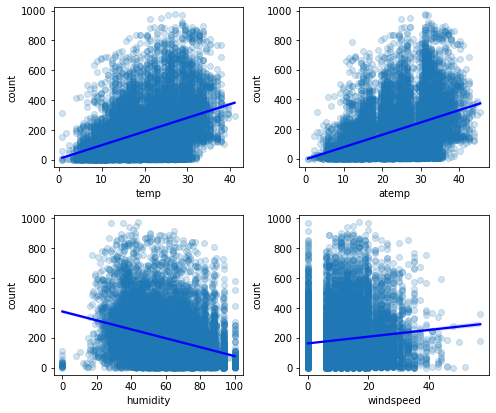

In [33]:
figure, axes = plt.subplots(nrows=2, ncols=2)
plt.tight_layout()
figure.set_size_inches(7, 6)

sns.regplot(data=bike_train, x='temp', y='count', ax=axes[0][0],
           scatter_kws={'alpha':0.2}, line_kws={'color' : 'blue'})
sns.regplot(data=bike_train, x='atemp', y='count', ax=axes[0][1],
           scatter_kws={'alpha':0.2}, line_kws={'color' : 'blue'})
sns.regplot(data=bike_train, x='humidity', y='count', ax=axes[1][0],
           scatter_kws={'alpha':0.2}, line_kws={'color' : 'blue'})
sns.regplot(data=bike_train, x='windspeed', y='count', ax=axes[1][1],
           scatter_kws={'alpha':0.2}, line_kws={'color' : 'blue'})

* 온도, 체감온도가 높을수록 대여 수량이 많음
* 습하지 않을수록 대여 수량이 많음
* 풍속이 셀수록 대여 수량이 많은지는 확실치가 않고
* 풍속이 0일 때 표시되어 있는 값을이 다수 발견되었고, 만약 결측치라면 제거하는 것 고려

- **(2)** 상관계수

In [34]:
bike_train[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()

,temp,atemp,humidity,windspeed,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,0.394454,0.389784,-0.317371,0.101369,1.000000


<AxesSubplot:>

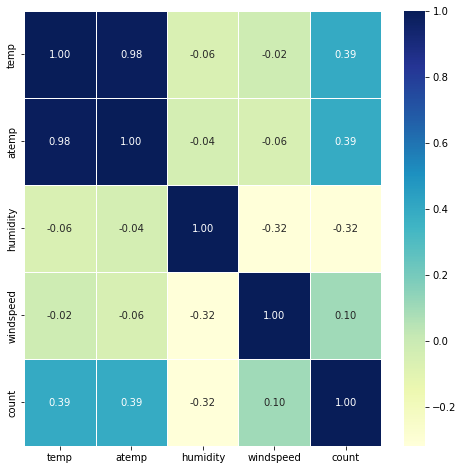

In [35]:
corr = bike_train[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()
plt.figure(figsize=(8,8)) # sns.heatmap 함수가 axes level api 이므로 figure 사이즈 조절 가능
sns.heatmap(corr, annot=True, fmt='.2f', linewidths=0.5, cmap='YlGnBu')

* 온도(temp)와 대여수량(count)간 상관계수 0.39(양의 상관관계)
* 풍속(windspeed)과 대여수량(count)간 상관계수는 0.1(상관관계가 매우 약함)
* windspeed는 대여 수량 예측에 별 도움을 주지 못하면서 결측치(0인값)도 많으므로 제거 고려

**선형회귀에서 다중공선성 문제(Multicollinearity in Regression)**
- https://towardsdatascience.com/multi-collinearity-in-regression-fe7a2c1467ea
- temp와 atemp가 상관관계가 높으므로 원하는 coef값이 나오지 않을 수 있음
- 두 특성 모두 예측변수에 양의 상관관계가 있으므로 coef가 양수값이 나오길 기대하지만
- 다중 선형회귀에선느 이 값이 바뀔 수 있음

## 5. 데이터 전처리

훈련 데이터와 테스트 데이터를 준비하는 방법
1. 훈련 데이터에 대한 전처리를 해준 뒤, 동일한 방법으로 테스트 데이터에 적용한다.
2. 훈련 데이터와 테스트 데이터를 합쳐서 모든 전처리가 끝난 뒤, 분리한다.

In [36]:
from IPython.display import Image
Image('./images/img5.png')

FileNotFoundError: No such file or directory: './images/img5.png'

FileNotFoundError: No such file or directory: './images/img5.png'

<IPython.core.display.Image object>

In [37]:
bike_train = pd.read_csv('datasets/bike_train.csv')
bike_test = pd.read_csv('datasets/bike_test.csv')
submission = pd.read_csv('datasets/sampleSubmission.csv')

### 5.1 이상치 제거

In [38]:
(bike_train['weather'] == 4).sum()

1

In [39]:
bike_train.shape

(10886, 12)

In [40]:
bike_train = bike_train[bike_train['weather'] != 4]

In [41]:
bike_train.shape

(10885, 12)

### 5.2 훈련 데이터와 테스트 데이터 합치기

In [42]:
pd.concat([bike_train, bike_test], axis=0) # 행축으로 연결

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


In [43]:
all_data = pd.concat([bike_train, bike_test], axis=0, ignore_index=True) # 행축으로 연결
all_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


### 5.3 datetime으로부터 파생특성 추가(특성 공학, feature engineering)

In [44]:
all_data['datetime'] = all_data.datetime.apply(pd.to_datetime)
all_data['year'] = all_data.datetime.apply(lambda x : x.year)
all_data['month'] = all_data.datetime.apply(lambda x : x.month)
all_data['hour'] = all_data.datetime.apply(lambda x : x.hour)
all_data['dayofweek'] = all_data.datetime.apply(lambda x : x.dayofweek) 

### 5.4 필요없는 특성 제거

In [45]:
drop_features = ['casual', 'registered', 'datetime', 'windspeed', 'month']
all_data = all_data.drop(drop_features, axis=1)

* 탐색적 데이터 분석에서 얻은 인사트를 활용해 의미있는 특성과 불필요한 특성을 구분(특성 선택)
- 특성이 많다고 무조건 좋은게 아님
- 예측 성능을 높이려면 타기값과 관련있는 특성이 필요
- 탐색적 데이터 분석, 상관관계 매트릭스 등의 배경지식을 종합적으로 활용해 판단해야 함
- 모델링 과정에서 특성 중요도(Tree model), 회귀 계수등을 참고해 볼 수 있음

### 5.5 훈련 데이터와 테스트 데이터 나누기

In [46]:
all_data[pd.isnull(all_data['count'])]

,season,holiday,workingday,weather,temp,atemp,humidity,count,year,hour,dayofweek
10885,1,0,1,1,10.66,11.365,56,NaN,2011,0,3
10886,1,0,1,1,10.66,13.635,56,NaN,2011,1,3
10887,1,0,1,1,10.66,13.635,56,NaN,2011,2,3
10888,1,0,1,1,10.66,12.880,56,NaN,2011,3,3
10889,1,0,1,1,10.66,12.880,56,NaN,2011,4,3
...,...,...,...,...,...,...,...,...,...,...,...
17373,1,0,1,2,10.66,12.880,60,NaN,2012,19,0
17374,1,0,1,2,10.66,12.880,60,NaN,2012,20,0
17375,1,0,1,1,10.66,12.880,60,NaN,2012,21,0
17376,1,0,1,1,10.66,13.635,56,NaN,2012,22,0


In [57]:
# Train/Test 데이터 분리하기
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]

In [58]:
# 타깃값, 특성 분리하기
y_train = X_train['count']
X_train = X_train.drop(['count'], axis=1)


X_test = X_test.drop(['count'], axis=1)
# y_test = 없음

In [59]:
X_train

,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,2011,0,5
1,1,0,0,1,9.02,13.635,80,2011,1,5
2,1,0,0,1,9.02,13.635,80,2011,2,5
3,1,0,0,1,9.84,14.395,75,2011,3,5
4,1,0,0,1,9.84,14.395,75,2011,4,5
...,...,...,...,...,...,...,...,...,...,...
10880,4,0,1,1,15.58,19.695,50,2012,19,2
10881,4,0,1,1,14.76,17.425,57,2012,20,2
10882,4,0,1,1,13.94,15.910,61,2012,21,2
10883,4,0,1,1,13.94,17.425,61,2012,22,2


In [60]:
X_test

,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,dayofweek
10885,1,0,1,1,10.66,11.365,56,2011,0,3
10886,1,0,1,1,10.66,13.635,56,2011,1,3
10887,1,0,1,1,10.66,13.635,56,2011,2,3
10888,1,0,1,1,10.66,12.880,56,2011,3,3
10889,1,0,1,1,10.66,12.880,56,2011,4,3
...,...,...,...,...,...,...,...,...,...,...
17373,1,0,1,2,10.66,12.880,60,2012,19,0
17374,1,0,1,2,10.66,12.880,60,2012,20,0
17375,1,0,1,1,10.66,12.880,60,2012,21,0
17376,1,0,1,1,10.66,13.635,56,2012,22,0


In [61]:
y_train

0         16.0
1         40.0
2         32.0
3         13.0
4          1.0
         ...  
10880    336.0
10881    241.0
10882    168.0
10883    129.0
10884     88.0
Name: count, Length: 10885, dtype: float64

## 6. 평가지표 계산 함수 작성

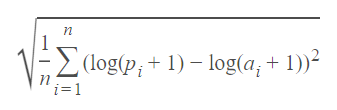

In [ ]:
Image('./images/img6.png')

In [ ]:
from sklearn.metrics import make_scorer
# log 값 변환 시 언더플로우 영향으로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
def rmsle(y, pred, convertExp=True):
    if convertExp:
        y = np.expm1(y)
        pred = np.expm1(pred)
    
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## 7. 모델 선택과 훈련

### 7.1 선형회귀 모델

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

In [ ]:
log_y = np.log1p(y_train)
lin_reg.fit(X_train, log_y)

LinearRegression()

### 7.2 잘못된 검증 (X_train으로 학습하고, X_train으로 검증을 했으므로)

In [ ]:
y_pred = lin_reg.predict(X_train)
rmsle(log_y, y_pred, True)

1.0183455499651857

### 7.3 모델 성능 검증(교차 검증)

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lin_reg, X_train, log_y, scoring=rmsle_scorer, cv=5)
-scores.mean() # 5개 교차 검증한 결과의 평균 rmsle

1.0259377040159592

In [ ]:
# 공식 문서에 나와 있는  predefined values(‘neg_mean_squared_log_error’)를 사용해도 되나
# underflow 처리가 안되어 있는 것으로 보임
# https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules
# scores = cross_val_score(lin_reg, X_train, y_train, scoring='neg_mean_squared_log_error', cv=5)
# -scores.mean()

C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("M

nan

### 7.4 규제모델(릿지, 라쏘, 엘라스티넷 모델)

In [ ]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# 모델 생성
ridge = Ridge()
lasso = Lasso()
elastic = ElasticNet()

In [ ]:
scores = cross_val_score(ridge, X_train, log_y, scoring=rmsle_scorer, cv=5)
-scores.mean() # 릿지모델을 5개 교차 검증한 결과의 평균 rmsle

1.0259457332657096

In [ ]:
scores= cross_val_score(lasso, X_train, log_y, scoring=rmsle_scorer, cv=5)
-scores.mean() # 라쏘모델을 5개 교차 검증한 결과의 평균 rmsle

1.1142719258697973

In [ ]:
scores = cross_val_score(elastic, X_train, log_y, scoring=rmsle_scorer, cv=5)
-scores.mean() # 엘라스틱넷 모델을 5개 교차 검증한 결과의 평균 rmsle

1.1035342525816867

## 8. 모델 세부 튜닝

In [ ]:
from sklearn.model_selection import GridSearchCV

### 8.1 릿지 모델

In [ ]:
ridge = Ridge()

ridge_params = {'alpha' : [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]} # 14개

gridsearch_ridge = GridSearchCV(ridge, ridge_params, scoring=rmsle_scorer, cv=5, n_jobs=-1) # 14 * 5

In [ ]:
%time gridsearch_ridge.fit(X_train, log_y)

Wall time: 6.33 s


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400,
                                   800, 900, 1000]},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [ ]:
gridsearch_ridge.best_params_

{'alpha': 0.1}

In [ ]:
cvres = gridsearch_ridge.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(-mean_score, params) # rmsle와 그 때의 하이퍼 파라미터

1.0259385051524947 {'alpha': 0.1}
1.0259457332657098 {'alpha': 1}
1.0259538020203387 {'alpha': 2}
1.0259619099095543 {'alpha': 3}
1.0259700565712468 {'alpha': 4}
1.0260197314469994 {'alpha': 10}
1.0261944516002468 {'alpha': 30}
1.0268953328557835 {'alpha': 100}
1.0280667404301447 {'alpha': 200}
1.0293631168653716 {'alpha': 300}
1.0307297219760279 {'alpha': 400}
1.036310230958598 {'alpha': 800}
1.0376557036987102 {'alpha': 900}
1.0389657418631324 {'alpha': 1000}


<AxesSubplot:>

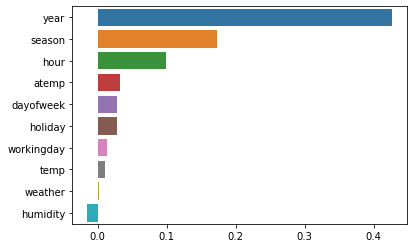

In [ ]:
coef = pd.Series(gridsearch_ridge.best_estimator_.coef_, index= X_train.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

### 8.2 랜덤포레스트

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_params = {'n_estimators' : [100, 120, 140]}
rnd_forest = RandomForestRegressor(random_state=42)

gridsearch_forest = GridSearchCV(rnd_forest, rf_params, scoring=rmsle_scorer, cv=5, n_jobs=-1)

%time gridsearch_forest.fit(X_train, log_y)

Wall time: 37.8 s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'n_estimators': [100, 120, 140]},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [ ]:
gridsearch_forest.best_params_

{'n_estimators': 140}

In [ ]:
cvres = gridsearch_forest.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(-mean_score, params) # rmsle와 그 때의 하이퍼 파라미터

0.4624358747986295 {'n_estimators': 100}
0.461783777710962 {'n_estimators': 120}
0.46092376487614306 {'n_estimators': 140}


In [ ]:
# best_model = gridsearch_forest.best_estimator_

In [ ]:
sorted(zip(gridsearch_forest.best_estimator_.feature_importances_, X_train.columns), reverse=True)

[(0.7595180825712268, 'hour'),
 (0.04792802447771889, 'temp'),
 (0.03752619933445052, 'workingday'),
 (0.03460172064058957, 'season'),
 (0.03269870315942869, 'year'),
 (0.029982293239748867, 'dayofweek'),
 (0.022842240593619653, 'humidity'),
 (0.021451786722442186, 'atemp'),
 (0.011859502465998137, 'weather'),
 (0.001591446794776728, 'holiday')]

### 8.3 그레디언트 부스팅 모델

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
gbrt_params = { 'learning_rate' : [0.01, 0.02, 0.03, 0.04], # 각 트리의 기여도
               'n_estimators' : [1000, 1500],
               'subsample' : [0.9, 0.5, 0.2],
               'max_depth' : [2, 4, 6, 8]
    
}

gbrt = GradientBoostingRegressor()

gridsearch_gbrt = GridSearchCV(gbrt, gbrt_params, scoring=rmsle_scorer, cv=5, n_jobs=-1)

In [ ]:
%time gridsearch_gbrt.fit(X_train, log_y)

Wall time: 33min 23s


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02, 0.03, 0.04],
                         'max_depth': [2, 4, 6, 8],
                         'n_estimators': [1000, 1500],
                         'subsample': [0.9, 0.5, 0.2]},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [ ]:
gridsearch_gbrt.best_params_

{'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 1500, 'subsample': 0.2}

In [ ]:
cvres = gridsearch_gbrt.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(-mean_score, params) # rmsle와 그 때의 하이퍼 파라미터

0.5906089141705806 {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 1000, 'subsample': 0.9}
0.579921762585159 {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 1000, 'subsample': 0.5}
0.5663741039667025 {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 1000, 'subsample': 0.2}
0.5471539011441585 {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 1500, 'subsample': 0.9}
0.5311834646856217 {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 1500, 'subsample': 0.5}
0.5145898623173469 {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 1500, 'subsample': 0.2}
0.4118950190737608 {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1000, 'subsample': 0.9}
0.3996996455607074 {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1000, 'subsample': 0.5}
0.3905148703809438 {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1000, 'subsample': 0.2}
0.39833687563844705 {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1500, 'subsample': 0.9}
0.38808278

In [ ]:
best_model = gridsearch_gbrt.best_estimator_

In [ ]:
sorted(zip(gridsearch_gbrt.best_estimator_.feature_importances_, X_train.columns), reverse=True)

[(0.7238389424392861, 'hour'),
 (0.04384496892905651, 'temp'),
 (0.0425674121293566, 'workingday'),
 (0.03834706261079211, 'dayofweek'),
 (0.035668256399721286, 'season'),
 (0.03370358086159958, 'year'),
 (0.0322601838824559, 'atemp'),
 (0.030783224044040294, 'humidity'),
 (0.016553611107436732, 'weather'),
 (0.0024327575962549927, 'holiday')]

## 9.모델 예측과 성능 평가

In [ ]:
X_test.shape

(6493, 10)

In [ ]:
best_pred = best_model.predict(X_test)
best_pred

array([2.46204042, 1.78796519, 1.3283687 , ..., 4.73332347, 4.42257987,
       3.82758356])

In [ ]:
submission['count'] = np.expm1(best_pred)

In [ ]:
ver = 1

In [ ]:
submission.to_csv('bike_{}_submission.csv'.format(ver), index=False)

# 더 해볼만한것!
- registered와 casual을 각각 예측해서 합산해보는 방법도 있음
- 더 강력한 모델(boosting 모델)로 도전